In [1]:
import sys, os
import pandas as pd

In [3]:
sys.path.append('/media/moraa/New Volume/Ontita/10Academy/Cohort B/Projects/Week1/User_Analytics_in_the_telecommunication_Industry')

from dotenv import load_dotenv
from src.components.db_connections import DBConnection
from src.components.clean import clean_data
#from components.plots import plot_distribution, plot_boxplot, plot_heatmap, plot_countplot, plot_histplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

In [4]:
# Create an instance of DBConnection
db_conn = DBConnection()

# Specify the table name you want to read
table_name = 'xdr_data'

# Read data from the specified table into a DataFrame
df = db_conn.read_table_to_dataframe(table_name)

df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [ ]:
# Create an instance of DataCleaner
cleaner = DataCleaner()

# Remove columns with missing values exceeding the threshold
df = cleaner.remove_columns_with_missing_values(df)

# Fill missing values in numerical columns
df = cleaner.fill_missing_values_numerical(df)

# Fill missing values in categorical columns
df = cleaner.fill_missing_values_categorical(df)

User Analysis Engagement

In [ ]:
# Calculate session frequency per customer
session_frequency = df['MSISDN/Number'].value_counts()

# Calculate session duration per customer
df['Session Duration (ms)'] = df['Dur. (ms)'] + df['Dur. (ms).1']
session_duration = df.groupby('MSISDN/Number')['Session Duration (ms)'].sum()

# Calculate total session traffic (download and upload) per customer
total_traffic = df.groupby('MSISDN/Number')[['Total DL (Bytes)', 'Total UL (Bytes)']].sum()
total_traffic['Total Session Traffic (Bytes)'] = total_traffic['Total DL (Bytes)'] + total_traffic['Total UL (Bytes)']

# Combine the aggregated metrics into a single DataFrame
engagement_metrics = pd.concat([session_frequency, session_duration, total_traffic], axis=1)

# Report the top 10 customers per engagement metric
print("Top 10 Customers per Engagement Metric:")
print("Top 10 Customers by Session Frequency:")
print(engagement_metrics.sort_values(by='MSISDN/Number', ascending=False).head(10))
print("\nTop 10 Customers by Total Session Duration:")
print(engagement_metrics.sort_values(by='Session Duration (ms)', ascending=False).head(10))
print("\nTop 10 Customers by Total Session Traffic:")
print(engagement_metrics.sort_values(by='Total Session Traffic (Bytes)', ascending=False).head(10))

Top 10 Customers per Engagement Metric:
Top 10 Customers by Session Frequency:
               count  Session Duration (ms)  Total DL (Bytes)  \
MSISDN/Number                                                   
8.823971e+14       1           8.707140e+08      7.869760e+07   
3.370000e+14       1           2.532832e+08      5.396350e+08   
3.197021e+12       1           8.782627e+08      1.948281e+08   
4.188282e+10    1066           7.262410e+10      4.873783e+11   
3.379000e+10       1           1.411296e+08      4.445751e+08   
3.379000e+10       1           8.819498e+06      6.879252e+08   
3.378998e+10       2           2.106005e+08      1.023862e+09   
3.378997e+10       1           1.606220e+08      1.740564e+08   
3.378996e+10       1           1.572269e+08      6.741405e+08   
3.378996e+10       1           9.892511e+07      5.958639e+08   

               Total UL (Bytes)  Total Session Traffic (Bytes)  
MSISDN/Number                                                   
8.823971e+

In [ ]:
# Extract the engagement metrics
engagement_metrics = df[['MSISDN/Number', 'Dur. (ms)', 'Total DL (Bytes)', 'Total UL (Bytes)']]

# Normalize the engagement metrics
scaler = StandardScaler()
normalized_engagement_metrics = scaler.fit_transform(engagement_metrics.drop(columns=['MSISDN/Number']))

# Run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(normalized_engagement_metrics)

# Create a copy of the DataFrame and add the cluster labels
engagement_metrics_copy = engagement_metrics.copy()
engagement_metrics_copy.loc[:, 'Cluster'] = clusters

# Print the counts of customers in each cluster
print("Counts of customers in each cluster:")
print(engagement_metrics_copy['Cluster'].value_counts())


Counts of customers in each cluster:
Cluster
0    69941
2    69212
1    10848
Name: count, dtype: int64


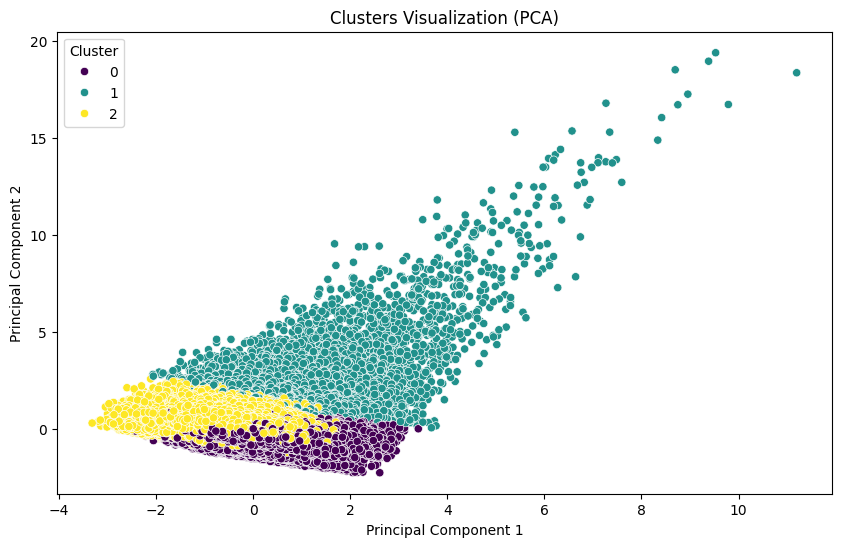

Cluster Characteristics:
         MSISDN/Number      Dur. (ms)  Total DL (Bytes)  Total UL (Bytes)
Cluster                                                                  
0         3.373364e+10   88866.526523      6.661058e+08      4.105459e+07
1         1.464057e+11  307575.615229      4.548788e+08      4.105212e+07
2         3.373536e+10   88704.193709      2.409169e+08      4.119935e+07


In [ ]:
# Visualize the clusters using PCA
pca = PCA(n_components=2)
engagement_metrics_pca = pca.fit_transform(normalized_engagement_metrics)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=engagement_metrics_pca[:, 0], y=engagement_metrics_pca[:, 1], hue=clusters, palette='viridis')
plt.title('Clusters Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# Calculate cluster centroids
cluster_centroids = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centroids_df = pd.DataFrame(cluster_centroids, columns=engagement_metrics.columns[:-1])

# Compare cluster characteristics
cluster_characteristics = engagement_metrics_copy.groupby('Cluster').mean()
print("Cluster Characteristics:")
print(cluster_characteristics)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

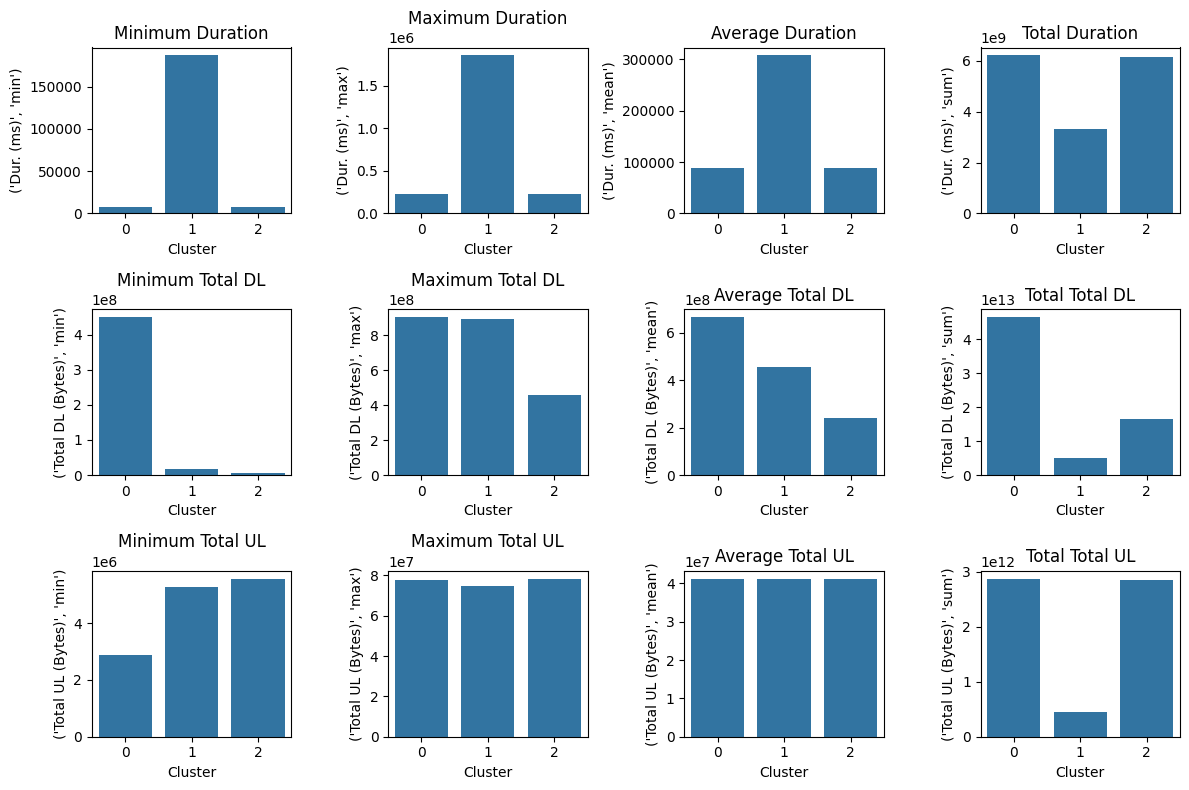

In [ ]:
# Group the engagement metrics by the cluster labels
cluster_metrics = engagement_metrics_copy.groupby('Cluster')

# Calculate minimum, maximum, average, and total metrics for each cluster
metrics_summary = cluster_metrics.agg({'Dur. (ms)': ['min', 'max', 'mean', 'sum'],
                                       'Total DL (Bytes)': ['min', 'max', 'mean', 'sum'],
                                       'Total UL (Bytes)': ['min', 'max', 'mean', 'sum']})

# Visualize the results
plt.figure(figsize=(12, 8))

# Plot minimum duration
plt.subplot(3, 4, 1)
sns.barplot(x=metrics_summary.index, y=('Dur. (ms)', 'min'), data=metrics_summary)
plt.title('Minimum Duration')

# Plot maximum duration
plt.subplot(3, 4, 2)
sns.barplot(x=metrics_summary.index, y=('Dur. (ms)', 'max'), data=metrics_summary)
plt.title('Maximum Duration')

# Plot average duration
plt.subplot(3, 4, 3)
sns.barplot(x=metrics_summary.index, y=('Dur. (ms)', 'mean'), data=metrics_summary)
plt.title('Average Duration')

# Plot total duration
plt.subplot(3, 4, 4)
sns.barplot(x=metrics_summary.index, y=('Dur. (ms)', 'sum'), data=metrics_summary)
plt.title('Total Duration')

# Plot minimum total DL
plt.subplot(3, 4, 5)
sns.barplot(x=metrics_summary.index, y=('Total DL (Bytes)', 'min'), data=metrics_summary)
plt.title('Minimum Total DL')

# Plot maximum total DL
plt.subplot(3, 4, 6)
sns.barplot(x=metrics_summary.index, y=('Total DL (Bytes)', 'max'), data=metrics_summary)
plt.title('Maximum Total DL')

# Plot average total DL
plt.subplot(3, 4, 7)
sns.barplot(x=metrics_summary.index, y=('Total DL (Bytes)', 'mean'), data=metrics_summary)
plt.title('Average Total DL')

# Plot total total DL
plt.subplot(3, 4, 8)
sns.barplot(x=metrics_summary.index, y=('Total DL (Bytes)', 'sum'), data=metrics_summary)
plt.title('Total Total DL')

# Plot minimum total UL
plt.subplot(3, 4, 9)
sns.barplot(x=metrics_summary.index, y=('Total UL (Bytes)', 'min'), data=metrics_summary)
plt.title('Minimum Total UL')

# Plot maximum total UL
plt.subplot(3, 4, 10)
sns.barplot(x=metrics_summary.index, y=('Total UL (Bytes)', 'max'), data=metrics_summary)
plt.title('Maximum Total UL')

# Plot average total UL
plt.subplot(3, 4, 11)
sns.barplot(x=metrics_summary.index, y=('Total UL (Bytes)', 'mean'), data=metrics_summary)
plt.title('Average Total UL')

# Plot total total UL
plt.subplot(3, 4, 12)
sns.barplot(x=metrics_summary.index, y=('Total UL (Bytes)', 'sum'), data=metrics_summary)
plt.title('Total Total UL')

plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Calculate total traffic per application per user
application_traffic = df[['MSISDN/Number', 'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
                                   'Google DL (Bytes)', 'Google UL (Bytes)',
                                   'Email DL (Bytes)', 'Email UL (Bytes)',
                                   'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                                   'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
                                   'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
                                   'Other DL (Bytes)', 'Other UL (Bytes)']]

# Group by 'MSISDN/Number' and sum the traffic for each application
user_application_traffic = application_traffic.groupby('MSISDN/Number').sum()

# Step 2: Summarize the total traffic for each application across all users
total_application_traffic = user_application_traffic.sum()

# Step 3: Identify the top 10 most engaged users for each application
top_10_users_per_application = {}
for column in user_application_traffic.columns:
    top_10_users_per_application[column] = user_application_traffic.nlargest(10, column)

# Print the top 10 most engaged users per application
for application, top_10_users in top_10_users_per_application.items():
    print(f"Top 10 most engaged users for {application}:")
    print(top_10_users)
    print()

Top 10 most engaged users for Social Media DL (Bytes):
               Social Media DL (Bytes)  Social Media UL (Bytes)  \
MSISDN/Number                                                     
4.188282e+10              1.937715e+09             3.610230e+07   
3.362632e+10              4.274384e+07             6.309420e+05   
3.376054e+10              3.929765e+07             4.855430e+05   
3.365973e+10              3.490044e+07             5.119140e+05   
3.361489e+10              2.774974e+07             5.448000e+05   
3.362578e+10              2.656412e+07             5.713790e+05   
3.366716e+10              2.375375e+07             4.940970e+05   
3.378632e+10              2.356866e+07             4.062640e+05   
3.366907e+10              2.347705e+07             3.237870e+05   
3.360313e+10              2.277668e+07             3.011460e+05   

               Google DL (Bytes)  Google UL (Bytes)  Email DL (Bytes)  \
MSISDN/Number                                                      

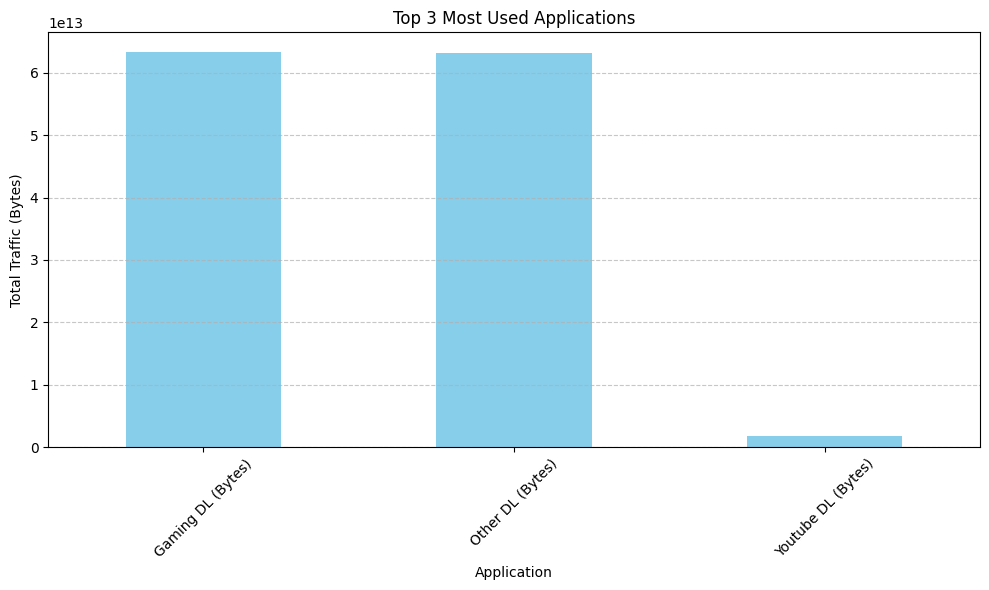

In [ ]:
# Step 1: Calculate total traffic per application
application_traffic = df[['Social Media DL (Bytes)', 'Social Media UL (Bytes)',
                                   'Google DL (Bytes)', 'Google UL (Bytes)',
                                   'Email DL (Bytes)', 'Email UL (Bytes)',
                                   'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                                   'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
                                   'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
                                   'Other DL (Bytes)', 'Other UL (Bytes)']]

total_application_traffic = application_traffic.sum()

# Step 2: Identify the top 3 most used applications
top_3_applications = total_application_traffic.nlargest(3)

# Step 3: Plot the top 3 most used applications
plt.figure(figsize=(10, 6))
top_3_applications.plot(kind='bar', color='skyblue')
plt.title('Top 3 Most Used Applications')
plt.xlabel('Application')
plt.ylabel('Total Traffic (Bytes)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

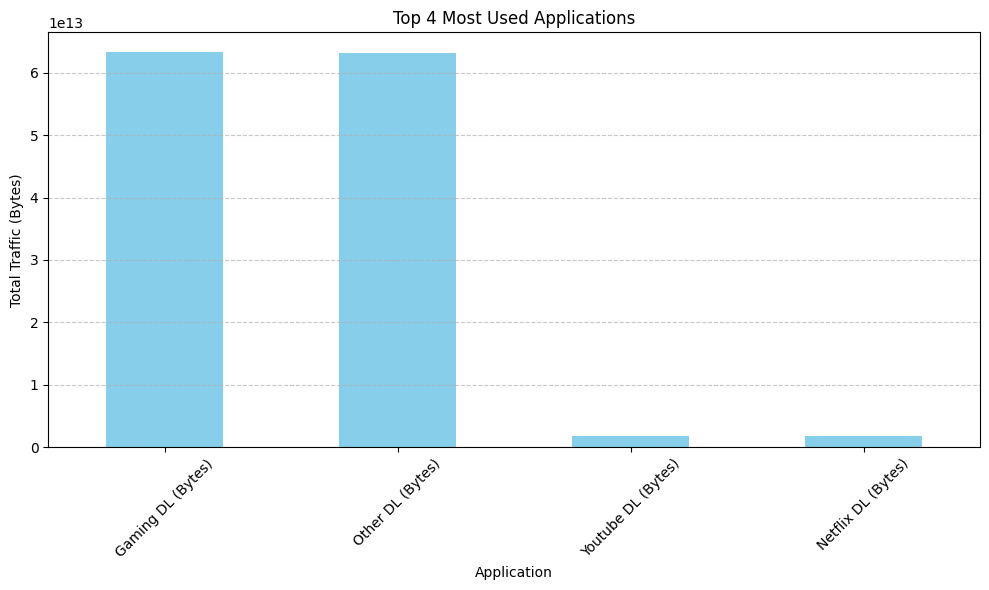

In [ ]:
# Step 1: Calculate total traffic per application
application_traffic = df[['Social Media DL (Bytes)', 'Social Media UL (Bytes)',
                                   'Google DL (Bytes)', 'Google UL (Bytes)',
                                   'Email DL (Bytes)', 'Email UL (Bytes)',
                                   'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                                   'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
                                   'Gaming DL (Bytes)', 'Gaming UL (Bytes)',
                                   'Other DL (Bytes)', 'Other UL (Bytes)']]

total_application_traffic = application_traffic.sum()

# Step 2: Identify the top 4 most used applications
top_4_applications = total_application_traffic.nlargest(4)

# Step 3: Plot the top 3 most used applications
plt.figure(figsize=(10, 6))
top_4_applications.plot(kind='bar', color='skyblue')
plt.title('Top 4 Most Used Applications')
plt.xlabel('Application')
plt.ylabel('Total Traffic (Bytes)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

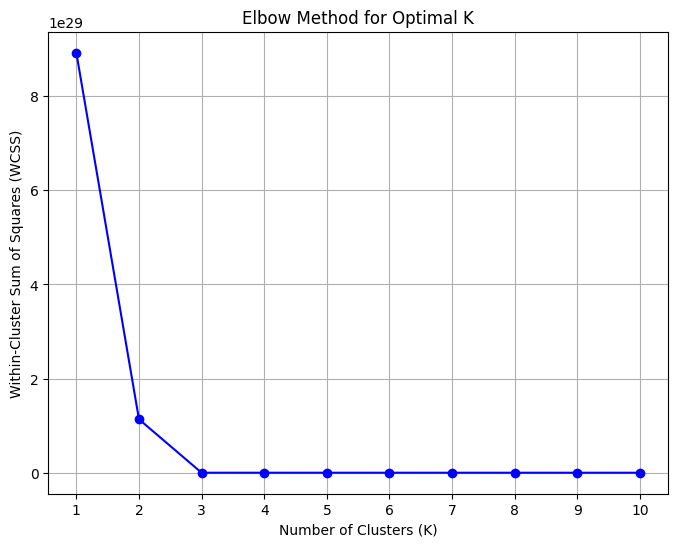

In [ ]:

# Extract engagement metrics
X = engagement_metrics.values

# Initialize list to store WCSS values for different k
wcss = []

# Try different values of k from 1 to 10
for k in range(1, 11):
    # Initialize KMeans model with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Fit the model to the data
    kmeans.fit(X)
    # Append the WCSS value to the list
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()